In [1]:
import numpy as np
import matplotlib.pyplot as plt
import agama

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Set the default font size for all text in the plot
plt.rcParams.update({'font.size': 16})

In [3]:
# Set up the logarithmic potential
v0 = 1.0  # Circular velocity
log_potential = dict(type='Logarithmic', v0=v0, axisRatioY=1.0, axisRatioZ=1.0, scaleRadius=0.0)
potential = agama.Potential(log_potential)

# Number of snapshots for plotting
nt = 1000

# Number of particles
N = 20000

# Fraction of Tcirc to integrate
fracT = 30

# Radial and velocity ranges
r0 = 1.0    # Starting radius
dr = 0.3    # Radial thickness
dv = 0.3    # Velocity thickness

# Initialize positions along x-axis (y = 0, z = 0), directed radially inward
x_i = r0 + dr * np.random.rand(N)  # x in [r0, r0 + dr]
y_i = np.zeros(N)
z_i = np.zeros(N)
positions = np.column_stack((x_i, y_i, z_i))

# Initialize velocities directed toward the center along x-axis
v_i = -(v0 + dv * np.random.rand(N))  # Negative to indicate inward motion
vx_i = v_i
vy_i = np.zeros(N) + 1e-32  # To avoid passing through 0,0
vz_i = np.zeros(N) + 1e-32
velocities = np.column_stack((vx_i, vy_i, vz_i))

# Combine positions and velocities into initial conditions
ic = np.hstack((positions, velocities))

# Compute the circular period at radius r0
T_circ = 2 * np.pi * r0 / v0

# Number of time steps for orbit integration nsteps > nt
nsteps = nt + 1

# Integrate the orbits
orbits = agama.orbit(
    potential=potential,
    ic=ic,
    time=fracT * T_circ,
    trajsize=nsteps
)

20000 orbits complete (463.8 orbits/s)


In [4]:
# Adjust ntimes to ensure it does not exceed nsteps
ntimes = min(nt + 1, nsteps)
indices = np.linspace(0, nsteps - 1, ntimes).astype(int)

# Initialize arrays to store positions and velocities at ntimes
positions_nt = np.zeros((ntimes, N, 3))
velocities_nt = np.zeros((ntimes, N, 3))

# Extract positions and velocities at desired times
for i in range(N):
    trajectory = orbits[i][1]  # Shape: (nsteps, 6)
    positions = trajectory[:, :3]
    velocities = trajectory[:, 3:]
    positions_nt[:, i, :] = positions[indices, :]
    velocities_nt[:, i, :] = velocities[indices, :]

# Extract x positions and vx velocities
x_nt = positions_nt[:, :, 0]
vx_nt = velocities_nt[:, :, 0]

# Define consistent axis limits for vx and x
x_min, x_max = np.min(x_nt), np.max(x_nt)
vx_min, vx_max = np.min(vx_nt), np.max(vx_nt)

# Number of bins
nx, nvx = 500, 500  # Fixed bin size for analysis

# Compute the number of particles in each phase-space pixel at each snapshot
particle_counts = []
for t in range(ntimes):
    H, _, _ = np.histogram2d(x_nt[t], vx_nt[t], bins=[nx, nvx], range=[[x_min, x_max], [vx_min, vx_max]])
    particle_counts.append(H.flatten())

# Convert particle counts to a numpy array
particle_counts = np.array(particle_counts)

# Compute the dispersion of the number of particles across all pixels at each time
dispersion = np.std(particle_counts, axis=1)

# Plot the dispersion over time
times = np.linspace(0, fracT * T_circ, ntimes)

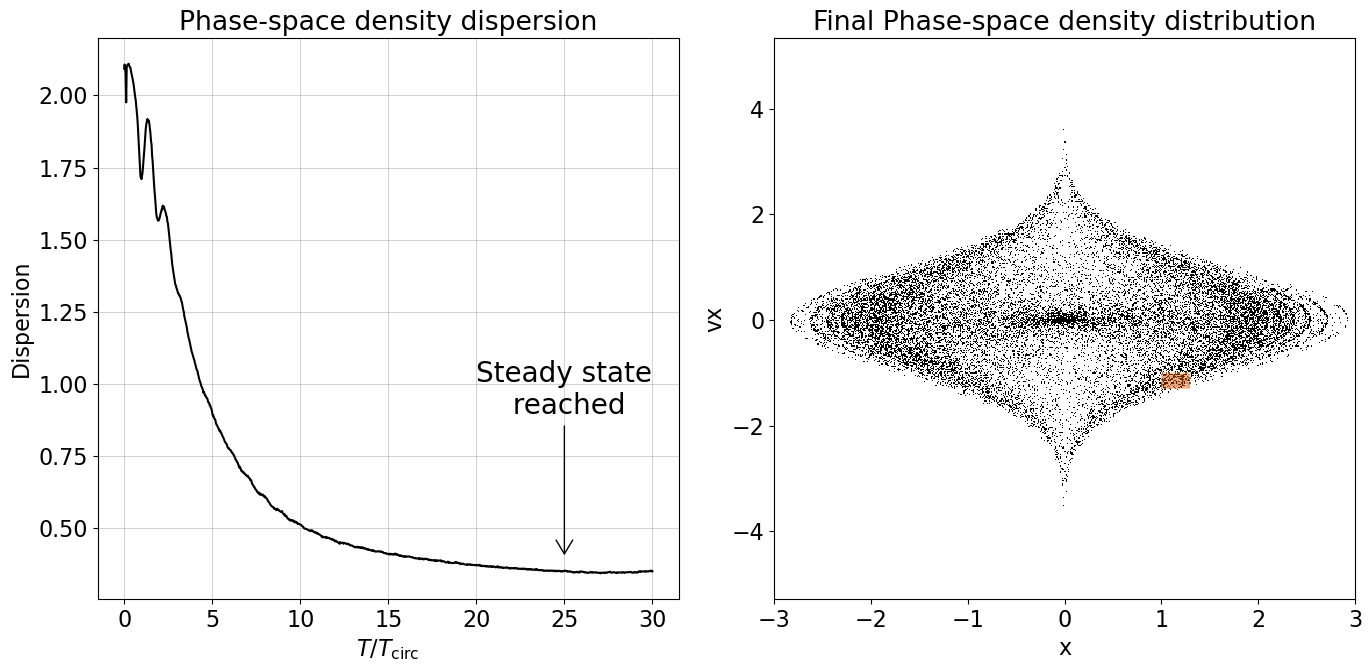

In [5]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=False)

# Panel 1: Dispersion over time
ax_cur = axes[0]
ax_cur.plot(times/T_circ, dispersion, color='black')
ax_cur.set_title("Phase-space density dispersion")
ax_cur.set_xlabel(r"$T/T_{\rm circ}$")
ax_cur.set_ylabel("Dispersion")
ax_cur.grid(visible=True, color='grey', alpha=0.5, linewidth=0.5)

# Add the vertical arrow
arrow_x = 25  # x-coordinate in T/T_circ
arrow_y_start = 0.3 * (max(dispersion) - min(dispersion)) + min(dispersion)  # y=0.3 in relative 
arrow_y_end = min(dispersion) + 0.03 * (max(dispersion) - min(dispersion))  # 0.03 in relative 
ax_cur.annotate(
    "Steady state\n reached",
    xy=(arrow_x, arrow_y_end),
    xytext=(arrow_x, arrow_y_start),
    arrowprops=dict(arrowstyle="->, head_width=0.3,head_length=0.5", color='black'),
    ha='center',
    va='bottom',
    fontsize=20
)

# Panel 2
ax_cur = axes[1]
H_final, xedges, yedges = np.histogram2d(
    x_nt[-1], vx_nt[-1], bins=[nx, nvx], range=[[x_min, x_max], [vx_min, vx_max]]
)
# Compute the 5th and 9th percentiles of the histogram counts
vmin = np.percentile(H_final, 2)
vmax = np.percentile(H_final, 98)

# Create the density plot with the specified scaling
X, Y = np.meshgrid(xedges, yedges)
c = ax_cur.pcolormesh(X, Y, H_final.T, shading='auto', cmap='Greys', vmin=vmin, vmax=vmax)
#fig.colorbar(c, ax=ax_cur, label="Number of Particles")
ax_cur.set_title("Final Phase-space density distribution")
ax_cur.set_xlabel("x")
ax_cur.set_ylabel("vx")

# Overlay the initial distribution, masking zero values
H_initial, _, _ = np.histogram2d(
    x_nt[0], vx_nt[0], bins=[nx, nvx], range=[[x_min, x_max], [vx_min, vx_max]]
)
H_initial_masked = np.ma.masked_where(H_initial == 0, H_initial)
ax_cur.pcolormesh(X, Y, H_initial_masked.T, shading='auto', cmap='Oranges', alpha=0.5)

# Adjust layout
plt.tight_layout()

plt.savefig("../Figures/phase_mixing.png", format="png", dpi=300, 
            facecolor='white', bbox_inches='tight')

plt.show()
